# Lab 6

You are tasked with evaluating card counting strategies for black jack. In order to do so, you will use object oriented programming to create a playable casino style black jack game where a computer dealer plays against $n$ computer players and possibily one human player. If you don't know the rules of blackjack or card counting, please google it. 

A few requirements:
* The game should utilize multiple 52-card decks. Typically the game is played with 6 decks.
* Players should have chips.
* Dealer's actions are predefined by rules of the game (typically hit on 16). 
* The players should be aware of all shown cards so that they can count cards.
* Each player could have a different strategy.
* The system should allow you to play large numbers of games, study the outcomes, and compare average winnings per hand rate for different strategies.

1. Begin by creating a classes to represent cards and decks. The deck should support more than one 52-card set. The deck should allow you to shuffle and draw cards. Include a "plastic" card, placed randomly in the deck. Later, when the plastic card is dealt, shuffle the cards before the next deal.

2. Now design your game on a UML diagram. You may want to create classes to represent, players, a hand, and/or the game. As you work through the lab, update your UML diagram. At the end of the lab, submit your diagram (as pdf file) along with your notebook. 

3. Begin with implementing the skeleton (ie define data members and methods/functions, but do not code the logic) of the classes in your UML diagram.

4. Complete the implementation by coding the logic of all functions. For now, just implement the dealer player and human player.

5.  Test. Demonstrate game play. For example, create a game of several dealer players and show that the game is functional through several rounds.

6. Implement a new player with the following strategy:

    * Assign each card a value: 
        * Cards 2 to 6 are +1 
        * Cards 7 to 9 are 0 
        * Cards 10 through Ace are -1
    * Compute the sum of the values for all cards seen so far.
    * Hit if sum is very negative, stay if sum is very positive. Select a threshold for hit/stay, e.g. 0 or -2.  

7. Create a test scenario where one player, using the above strategy, is playing with a dealer and 3 other players that follow the dealer's strategy. Each player starts with same number of chips. Play 50 rounds (or until the strategy player is out of money). Compute the strategy player's winnings. You may remove unnecessary printouts from your code (perhaps implement a verbose/quiet mode) to reduce the output.

8. Create a loop that runs 100 games of 50 rounds, as setup in previous question, and store the strategy player's chips at the end of the game (aka "winnings") in a list. Histogram the winnings. What is the average winnings per round? What is the standard deviation. What is the probabilty of net winning or lossing after 50 rounds?


9. Repeat previous questions scanning the value of the threshold. Try at least 5 different threshold values. Can you find an optimal value?

10. Create a new strategy based on web searches or your own ideas. Demonstrate that the new strategy will result in increased or decreased winnings. 

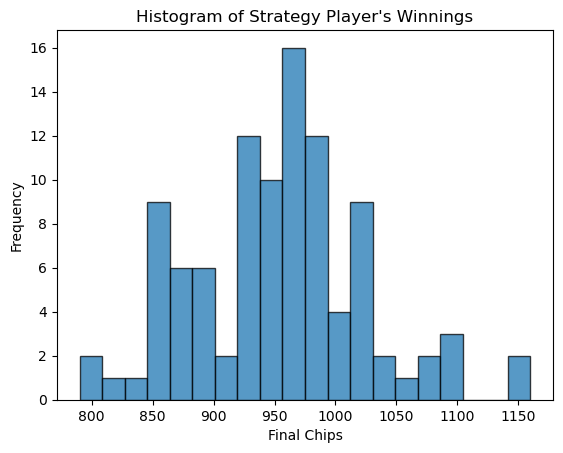

Average winnings: 953.8
Standard deviation: 71.31311239877279
Probability of winning: 0.21
Probability of losing: 0.77


In [6]:
import random
import numpy as np
import matplotlib.pyplot as plt

# Card class representing individual cards
class Card:
    def __init__(self, suit, rank, value):
        self.suit = suit
        self.rank = rank
        self.value = value
    
    def __str__(self):
        return f"{self.rank} of {self.suit}"

# Deck class representing multiple decks of cards
class Deck:
    suits = ['Hearts', 'Diamonds', 'Clubs', 'Spades']
    ranks = ['2', '3', '4', '5', '6', '7', '8', '9', '10', 'J', 'Q', 'K', 'A']
    values = {'2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, '8': 8, '9': 9, '10': 10, 'J': 10, 'Q': 10, 'K': 10, 'A': 11}
    
    def __init__(self, num_decks=6):
        # Initializing the deck with multiple decks
        self.num_decks = num_decks
        self.initialize_deck()
    
    def initialize_deck(self):
        self.cards = [Card(suit, rank, self.values[rank]) for suit in self.suits for rank in self.ranks] * self.num_decks
        self.shuffle()
        self.plastic_card = random.randint(20, len(self.cards) - 20)
    
    def shuffle(self):
        random.shuffle(self.cards)
    
    def draw_card(self):
        if not self.cards:  # If the deck is empty, reinitialize and shuffle
            self.initialize_deck()
        return self.cards.pop()

# Player class representing the players in the game
class Player:
    def __init__(self, name, chips=1000):
        self.name = name
        self.chips = chips
        self.hand = []
        self.count = 0  # Card counting value
    
    def place_bet(self, amount):
        if amount > self.chips:
            return False
        self.chips -= amount
        return True
    
    def receive_card(self, card):
        if card:
            self.hand.append(card)
            self.update_count(card)
    
    def clear_hand(self):
        self.hand = []
    
    def hand_value(self):
        value = sum(card.value for card in self.hand)
        aces = sum(1 for card in self.hand if card.rank == 'A')
        while value > 21 and aces:
            value -= 10
            aces -= 1
        return value
    
    def is_busted(self):
        return self.hand_value() > 21
    
    # Implementing the card counting strategy
    def update_count(self, card):
        if card.rank in ['2', '3', '4', '5', '6']:
            self.count += 1
        elif card.rank in ['10', 'J', 'Q', 'K', 'A']:
            self.count -= 1

    # Strategy decision based on card counting
    def strategy_decision(self):
        if self.count <= -2:
            return "hit"
        return "stand"

# Dealer class inherits from Player
class Dealer(Player):
    def __init__(self):
        super().__init__("Dealer")
    
    def play(self, deck):
        while self.hand_value() < 17:
            self.receive_card(deck.draw_card())

# BlackjackGame class to handle multiple players and game simulation
class BlackjackGame:
    def __init__(self, num_players=4):
        self.deck = Deck()
        self.dealer = Dealer()
        self.players = [Player(f"Player {i+1}") for i in range(num_players - 1)]
        self.strategy_player = Player("Strategy Player")
        self.players.append(self.strategy_player)
    
    def deal_initial_cards(self):
        for _ in range(2):
            for player in self.players:
                player.receive_card(self.deck.draw_card())
            self.dealer.receive_card(self.deck.draw_card())
    
    def play_round(self):
        self.deal_initial_cards()
        
        for player in self.players:
            while player.hand_value() < 17 or (player == self.strategy_player and player.strategy_decision() == "hit"):
                player.receive_card(self.deck.draw_card())
        
        self.dealer.play(self.deck)
        self.resolve_bets()
    
    def resolve_bets(self):
        dealer_value = self.dealer.hand_value()
        for player in self.players:
            player_value = player.hand_value()
            if player.is_busted() or (dealer_value <= 21 and dealer_value > player_value):
                player.chips -= 10
            elif dealer_value > 21 or player_value > dealer_value:
                player.chips += 10

    def play_multiple_rounds(self, num_rounds=50):
        for _ in range(num_rounds):
            self.play_round()
            for player in self.players:
                player.clear_hand()
            self.dealer.clear_hand()
        return self.strategy_player.chips
    
    def simulate_games(self, num_games=100):
        winnings = []
        for _ in range(num_games):
            self.strategy_player.chips = 1000
            winnings.append(self.play_multiple_rounds())
        return winnings
    
    def analyze_strategy(self):
        winnings = self.simulate_games()
        avg_winnings = np.mean(winnings)
        std_dev = np.std(winnings)
        probability_winning = sum(1 for w in winnings if w > 1000) / len(winnings)
        probability_losing = sum(1 for w in winnings if w < 1000) / len(winnings)
        
        # Histogram visualization
        plt.hist(winnings, bins=20, alpha=0.75, edgecolor='black')
        plt.xlabel("Final Chips")
        plt.ylabel("Frequency")
        plt.title("Histogram of Strategy Player's Winnings")
        plt.show()
        
        return avg_winnings, std_dev, probability_winning, probability_losing

# Running the analysis
game = BlackjackGame()
avg_winnings, std_dev, prob_win, prob_loss = game.analyze_strategy()
print(f"Average winnings: {avg_winnings}")
print(f"Standard deviation: {std_dev}")
print(f"Probability of winning: {prob_win}")
print(f"Probability of losing: {prob_loss}")
